In [30]:
import os
from metpy.calc.thermo import _find_append_zero_crossings
from metpy.calc.thermo import _greater_or_close
from metpy.calc.thermo import _less_or_close
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import scipy.io
from metpy.constants import Rd, Cp_d, Lv, g 

import matplotlib.pyplot as plt

In [41]:
def el(pressure, temperature, dewpt, parcel_temperature_profile=None):

    # Default to surface parcel if no profile or starting pressure level is given
    if parcel_temperature_profile is None:
        new_stuff = mpcalc.parcel_profile_with_lcl(pressure, temperature, dewpt)
        pressure, temperature, _, parcel_temperature_profile = new_stuff
        temperature = temperature.to('degC')
        parcel_temperature_profile = parcel_temperature_profile.to('degC')

    # If the top of the sounding parcel is warmer than the environment, there is no EL
    if parcel_temperature_profile[-1] > temperature[-1]:
        return np.nan * pressure.units, np.nan * temperature.units

    # Otherwise the last intersection (as long as there is one) is the EL
    x, y = mpcalc.find_intersections(pressure[1:], parcel_temperature_profile[1:], temperature[1:])
    if len(x) > 0:
    ##################  modified section #############
#       return x[-1], y[-1]  # original el, find the last interestciton (X)
    
        lfc = mpcalc.lfc(pressure, temperature, dewpt, parcel_temperature_profile)[0]
        el_idx = np.where(x < lfc)[0][0] # find the first intersection above LFC where Tp becomes cooler than Tenv (O)
        return x[el_idx], y[el_idx]
    ##################################################
    
    
    else:
        return np.nan * pressure.units, np.nan * temperature.units

In [42]:
def cape_cin(pressure, temperature, dewpt, parcel_profile):
    # Calculate LFC limit of integration
    lfc_pressure, _ = mpcalc.lfc(pressure, temperature, dewpt,
                          parcel_temperature_profile=parcel_profile)

    # If there is no LFC, no need to proceed.
    if np.isnan(lfc_pressure):
        return 0 * units('J/kg'), 0 * mpunits('J/kg')
    else:
        lfc_pressure = lfc_pressure.magnitude

    # Calculate the EL limit of integration
    el_pressure, _ = el(pressure, temperature, dewpt,
                        parcel_temperature_profile=parcel_profile)

    # No EL and we use the top reading of the sounding.
    if np.isnan(el_pressure):
        el_pressure = pressure[-1].magnitude
    else:
        el_pressure = el_pressure.magnitude

    # Difference between the parcel path and measured temperature profiles
    y = (parcel_profile - temperature).to(units.degK)

    # Estimate zero crossings
    x, y = _find_append_zero_crossings(np.copy(pressure), y)

    # CAPE
    # Only use data between the LFC and EL for calculation
    p_mask = _less_or_close(x, lfc_pressure) & _greater_or_close(x, el_pressure)
    x_clipped = x[p_mask]
    y_clipped = y[p_mask]
    cape = (Rd * (np.trapz(y_clipped, np.log(x_clipped)) * units.degK)).to(units('J/kg'))

    # CIN
    # Only use data between the surface and LFC for calculation
    p_mask = _greater_or_close(x, lfc_pressure)
    x_clipped = x[p_mask]
    y_clipped = y[p_mask]
    cin = (Rd * (np.trapz(y_clipped, np.log(x_clipped)) * units.degK)).to(units('J/kg'))

    return cape, cin    

In [43]:
def msed_plots(pressure,temperature,mixing_ratio,altitude=None):
    """
    plotting the summarized static energy diagram with annotations and thermodynamic parameters
    """
    q  = mixing_ratio
    qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(temperature*units.degC),pressure*units.mbar)
    Td = mpcalc.dewpoint(mpcalc.vapor_pressure(pressure*units.mbar,q*units.kilogram/units.kilogram)).magnitude # dewpoint 
    Tp = mpcalc.parcel_profile(pressure*units.mbar, temperature[0]*units.degC, Td[0]*units.degC).to('degC').magnitude; # parcel

    # Altitude 
    if (altitude is None):
        altitude = np.zeros((np.size(temperature))) # surface is 0 meter
        for i in range(1,np.size(temperature)):
            altitude[i] = mpcalc.thickness_hydrostatic(pressure[:i+1]*units.mbar,temperature[:i+1]*units.degC).magnitude; # Hypsometric Eq. for height

        else:
            altitide = altitude
  
    # Static energy calculations   
    mse = mpcalc.moist_static_energy(altitude*units.meter,temperature*units.degC,q*units.kilogram/units.kilogram).magnitude
    mse_s = mpcalc.moist_static_energy(altitude*units.meter,temperature*units.degC,qs*units.kilogram/units.kilogram).magnitude
    dse = mpcalc.dry_static_energy(altitude*units.meter,temperature*units.degC)

    # Water vapor calculations
    p_PWtop = max(200*units.mbar, min(pressure*units.mbar) +1*units.mbar) # integrating until 200mb 
    cwv = mpcalc.precipitable_water(Td*units.degC,pressure*units.mbar, top=p_PWtop) # column water vapor [mm]
    cwvs = mpcalc.precipitable_water(temperature*units.degC,pressure*units.mbar, top=p_PWtop) # saturated column water vapor [mm]
    crh = (cwv/cwvs).magnitude *100. # column relative humidity [%]

    #================================================
    # plotting MSE vertical profiles
    h=plt.figure(figsize=[10,8])
    plt.plot(dse[:],pressure[:],'-k',linewidth=2)
    plt.plot(mse[:],pressure[:],'-b',linewidth=2)
    plt.plot(mse_s[:],pressure[:],'-r',linewidth=2)
    
    # mse based on different percentages of relative humidity
    qr=np.zeros((9,np.size(qs.magnitude))); mse_r=qr# container
    for i in range(9):
        qr[i,:]=qs*0.1*(i+1);
        mse_r[i,:]=(Cp_d.magnitude*(temperature+273.15)+g.magnitude*altitude+Lv.magnitude*qr[i,:])/1000;

    for i in range(9):
        plt.plot(mse_r[i,:],pressure[:],'-',color='grey',linewidth=0.7)
        plt.text(mse_r[i,3]-1,pressure[3],str((i+1)*10))
                
    # drawing LCL and LFC levels
    [lcl_pressure, lcl_temperature] = mpcalc.lcl(pressure[0]*units.mbar, temperature[0]*units.degC, Td[0]*units.degC)
    lcl_idx = np.argmin(np.abs(pressure - lcl_pressure.magnitude))
    line_lcl=np.squeeze(np.ones((1,300))*lcl_pressure);
    plt.plot(np.linspace(280,400,300),line_lcl,'--',color='orange')
    
    [lfc_pressure,lfc_idx]=mpcalc.lfc(pressure*units.mbar,temperature*units.degC,Td*units.degC)
    line_lfc=np.squeeze(np.ones((1,300))*lfc_pressure);
    plt.plot(np.linspace(280,400,300),line_lfc,'--',color='magenta')
    
    # conserved mse of air parcel arising from 1000 hpa    
    mse_p=np.squeeze(np.ones((1,np.size(temperature)))*mse[0]);
    
    # illustration of CAPE
    el_pressure,el_temperature = el(pressure*units.mbar,temperature*units.degC,Td*units.degC) # equilibrium level
    el_idx = np.argmin(np.abs(pressure - el_pressure.magnitude))
    [CAPE,CIN]=mpcalc.cape_cin(pressure[:el_idx]*100*units.pascal,temperature[:el_idx]*units.degC,Td[:el_idx]*units.degC,Tp[:el_idx]*units.degC)
    
    plt.plot(mse_p[:],pressure[:],color='green',linewidth=2)
    plt.fill_betweenx(pressure[lcl_idx:el_idx+1],mse_p[lcl_idx:el_idx+1],mse_s[lcl_idx:el_idx+1],interpolate=True
                    ,color='green',alpha='0.3');

    plt.fill_betweenx(pressure[:],dse[:],mse[:],color='deepskyblue',alpha='0.5')
    plt.xlim([280,380])
    plt.xlabel('Specific static energy, hs, h, S [KJ/kg]',fontsize=14)
    plt.ylabel('Pressure [hpa]',fontsize=14)
    plt.xticks(fontsize=12);plt.yticks(fontsize=12)
    plt.ylim(1030,150)
    
    # Depict Entraining parcels
    # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
    # M=1 at ground without loss of generality
    entrainment_distance = 10000., 5000., 2000. 

    for ED in entrainment_distance: 
        eps = 1.0 / (ED)
        M = np.exp(eps * (altitude-altitude[0]));

        # dM is the mass contribution at each level, with 1 at the origin level. 
        M[0] = 0
        dM = np.gradient(M)

        # parcel mass is a  sum of all the dM's at each level
        # conserved linearly-mixed variables like h are weighted averages 
        hent = np.cumsum(dM*mse) / np.cumsum(dM)

        plt.plot( hent[0:el_idx+3], pressure[0:el_idx+3], linewidth=0.5, color='g')

    # Text parts
    plt.text(290,pressure[3],'RH (%)',fontsize=11,color='k')
    plt.text(285,250,'CAPE = '+str(np.around(CAPE.magnitude,decimals=2))+' [J/kg]',fontsize=14,color='green');
    plt.text(285,300,'CIN = '+str(np.around(CIN.magnitude,decimals=2))+' [J/kg]',fontsize=14,color='green')
    plt.text(285,350,'LCL = '+str(np.around(lcl_pressure.magnitude,decimals=2))+' [hpa]',fontsize=14,color='orange');
    plt.text(285,400,'LFC = '+str(np.around(lfc_pressure.magnitude,decimals=2))+' [hpa]',fontsize=14,color='magenta');
    plt.text(285,450,'CWV = '+str(np.around(cwv.magnitude,decimals=2))+' [mm]',fontsize=14,color='deepskyblue');
    plt.text(285,500,'CRH = '+str(np.around(crh,decimals=2))+' [%]',fontsize=14,color='blue');
    plt.text(330,220,'entrain: \n 10,5,2 km',fontsize=12,color='green');
    plt.text(mse[0]-3,400,'Parcel h',fontsize=12,color='green')
    plt.legend(['dry air','moist air','saturated air'],fontsize=12,loc=1);
    return (plt)

In [44]:
os.getcwd()

'/Users/willy/Desktop'

In [ ]:
#Leer q
qcd = scipy.io.loadmat('./IOP1/qcd.mat')
qcd1=qcd['qcd'][:,1]
qcd2=qcd1/1000

#Leer p
pp=np.arange(1000,90,-10)

#Leer t
tcd = scipy.io.loadmat('./IOP1/Tcd.mat')
tcd1=tcd['Tcd'][:,1]

#Leer z
zcd = scipy.io.loadmat('./IOP1/Zcd.mat')
zcd1=zcd['Zcd'][:,1]

### Modified MSEplot with the accurate EL (~730mb),  defined as the first intersection where Tp is cooler than the environment above LFC.

<module 'matplotlib.pyplot' from '/Users/willy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

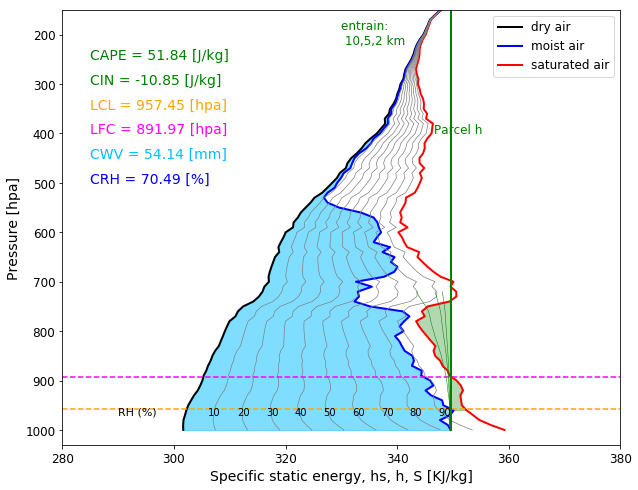

In [50]:
msed_plots(pp,tcd1,qcd2) # msed_plot with modified EL

### Current MSEplot based on the original EL (~180 mbar) calculated in MetPy

<module 'matplotlib.pyplot' from '/Users/willy/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

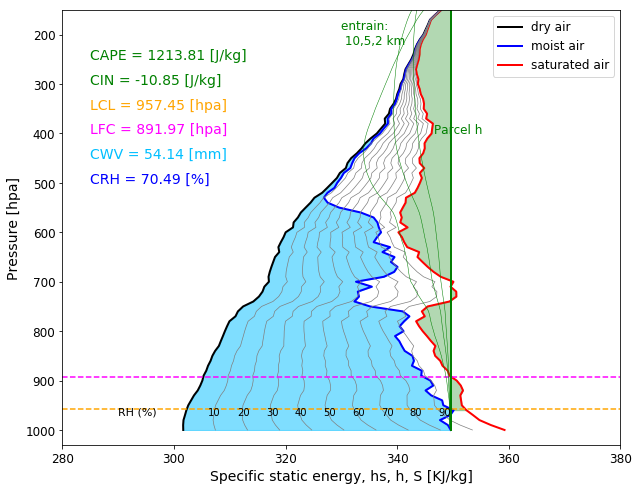

In [48]:
from MSEplots import plots as mpt
mpt.msed_plots(pp,tcd1,qcd2)